In [ ]:
!pip install accelerate datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is inco

In [ ]:
!pip install accelerate datasets evaluate transformers matplotlib seaborn wordcloud scikit-learn --quiet

from datasets import load_dataset
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
import evaluate
import os

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths in Google Drive
model_path = "/content/drive/MyDrive/fabert_food_reviews_model_ft2"
tokenizer_path = "/content/drive/MyDrive/fabert_food_reviews_tokenizer_ft2"

In [ ]:
# Load the dataset
my_dataset = load_dataset("PNLPhub/snappfood-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/52110 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8337 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9033 [00:00<?, ? examples/s]

In [ ]:
my_dataset = my_dataset.remove_columns(['label_id'])

In [ ]:
# Convert string labels to numeric values
label_map = {"SAD": 1, "HAPPY": 0}
my_dataset = my_dataset.map(lambda example: {"label": label_map[example["label"]]}, remove_columns=["label"])


Map:   0%|          | 0/52110 [00:00<?, ? examples/s]

Map:   0%|          | 0/8337 [00:00<?, ? examples/s]

Map:   0%|          | 0/9033 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer
# Tokenize the text data
model_name = "sbunlp/fabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    tokenized_text = tokenizer(examples['comment'], truncation=True, padding="max_length", max_length=512)
    return {"input_ids": tokenized_text["input_ids"], "attention_mask": tokenized_text["attention_mask"], "label": examples["label"]}

tokenized_dataset = my_dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/552k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map:   0%|          | 0/52110 [00:00<?, ? examples/s]

Map:   0%|          | 0/8337 [00:00<?, ? examples/s]

Map:   0%|          | 0/9033 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import evaluate
# Define metrics and model
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

In [ ]:
from transformers import DataCollatorWithPadding
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_result = accuracy.compute(predictions=predictions, references=labels)['accuracy']
    f1_result = f1.compute(predictions=predictions, references=labels, average='macro')['f1']
    return {"accuracy": accuracy_result, "f1": f1_result}

id2label = {
    0: "HAPPY",
    1: "SAD",
}
label2id = {
    "HAPPY": 0,
    "SAD": 1,
}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Check if model exists in Google Drive
model_exists = os.path.exists(model_path) and os.path.exists(tokenizer_path)

if not model_exists:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label), id2label=id2label, label2id=label2id)

    training_args = TrainingArguments(
        output_dir=model_path,
        learning_rate=2e-5,
        per_device_train_batch_size=24,
        per_device_eval_batch_size=24,
        num_train_epochs=2,
        weight_decay=0.005,
        warmup_ratio=0,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()

    # Save the model and tokenizer
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)
else:
    print("Loading pre-trained model...")
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)


config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sbunlp/fabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.290200,0.293465,0.880653,0.880112
2,0.235200,0.294559,0.882332,0.882177


In [ ]:
# Evaluate the model
print("Evaluating the model...")
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir=model_path,
        per_device_eval_batch_size=32,
    ),
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
evaluation_results = trainer.evaluate()
print("Evaluation results:", evaluation_results)

Evaluating the model...


Evaluation results: {'eval_loss': 0.2945593297481537, 'eval_accuracy': 0.8823317740194314, 'eval_f1': 0.8821771689476667, 'eval_runtime': 233.9978, 'eval_samples_per_second': 35.629, 'eval_steps_per_second': 1.115}


In [ ]:
# Import necessary modules
import torch

# Define a function to predict the sentiment of a given sentence
def predict_sentiment(sentence, model, tokenizer):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    # Move the inputs to the same device as the model (CPU or GPU)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    # Perform the prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    predictions = outputs.logits.argmax(dim=-1).item()

    # Convert the predicted class to the sentiment label
    sentiment = id2label[predictions]

    return sentiment

# Test the model with a specific Persian sentence
persian_sentence = "آقو این غذا مشتی بود، مرسی."  # Replace this with your Persian sentence
predicted_sentiment = predict_sentiment(persian_sentence, model, tokenizer)

print(f"The predicted sentiment for the given sentence is: {predicted_sentiment}")


The predicted sentiment for the given sentence is: HAPPY


In [ ]:
# Analyze the model with various Persian sentences including slang, cultural references, and dialects
persian_sentences = [
    # Slang and Informal Lexicon
    "غذاش خیلی خفن بود، حال کردم!",  # Positive
    "این رستوران تهرونیه، هم خوشمزه‌ست هم باکلاس.",  # Positive
    "آقا دمتون گرم، خیلی چسبید!",  # Positive
    "غذا افتضاح بود، اصلاً حال نکردم.",  # Negative
     "طرف خودشو جر داد تا غذا رو برسونه به دستمون.",  # Negative
    "دیر رسید و مزه‌اش داغون بود.",  # Negative
    "این رستوران اصلاً به درد نمی‌خوره.",  # Negative

    # Cultural References
    "این غذا منو یاد نذری‌های محرم می‌ندازه.",  # Positive
    "طعم غذاتون عین غذای خونه مادربزرگه.",  # Positive
    "اینجا آدمو یاد جشن‌های یلدایی می‌ندازه.",  # Positive
    "غذا مثل قورمه‌سبزی بی‌نمک بود.",  # Negative
    "این غذا اصلاً به پای پلوهای مامانم نمی‌رسه.",  # Negative
    "اینجا اصلاً حال و هوای رستوران‌های سنتی رو نداره.",  # Negative

    # Dialects from Different Regions
    "آقو این غذا مشتی بود، مرسی.",  # Positive
    "ای خدا، این غذا خیلی شنگولم کرد.",  # Positive
    "غذاشون خوب بید، راضی بیدم.",  # Positive
    "نه بابا، این غذا خیلی بد مزه بید.",  # Negative
    "آخه این چه غذایی بید؟ اصلاً خوشم نیومد.",  # Negative
    "ای غذای شما اصلاً نمی‌شه خورد."  # Negative
]

# Predict and print the sentiment for each sentence
for sentence in persian_sentences:
    predicted_sentiment = predict_sentiment(sentence, model, tokenizer)
    print(f"Sentence: \"{sentence}\" -> Predicted Sentiment: {predicted_sentiment}")


Sentence: "غذاش خیلی خفن بود، حال کردم!" -> Predicted Sentiment: HAPPY
Sentence: "این رستوران تهرونیه، هم خوشمزه‌ست هم باکلاس." -> Predicted Sentiment: HAPPY
Sentence: "آقا دمتون گرم، خیلی چسبید!" -> Predicted Sentiment: HAPPY
Sentence: "غذا افتضاح بود، اصلاً حال نکردم." -> Predicted Sentiment: SAD
Sentence: "طرف خودشو جر داد تا غذا رو برسونه به دستمون." -> Predicted Sentiment: SAD
Sentence: "دیر رسید و مزه‌اش داغون بود." -> Predicted Sentiment: SAD
Sentence: "این رستوران اصلاً به درد نمی‌خوره." -> Predicted Sentiment: SAD
Sentence: "این غذا منو یاد نذری‌های محرم می‌ندازه." -> Predicted Sentiment: HAPPY
Sentence: "طعم غذاتون عین غذای خونه مادربزرگه." -> Predicted Sentiment: HAPPY
Sentence: "اینجا آدمو یاد جشن‌های یلدایی می‌ندازه." -> Predicted Sentiment: HAPPY
Sentence: "غذا مثل قورمه‌سبزی بی‌نمک بود." -> Predicted Sentiment: SAD
Sentence: "این غذا اصلاً به پای پلوهای مامانم نمی‌رسه." -> Predicted Sentiment: SAD
Sentence: "اینجا اصلاً حال و هوای رستوران‌های سنتی رو نداره." -> Predicted

In [ ]:
# Analyze the model with various Persian sentences including idiomatic expressions, linguistic nuances, and Gilaki dialect
persian_sentences = [
    # Idiomatic Expressions
    "غذا مثل عسل بود، خیلی چسبید!",  # Positive
    "انگار ماهی از آب گرفتی، خیلی تازه بود.",  # Positive
    "رستورانتون گل کاشت، خیلی خوشمزه بود.",  # Positive
    "غذاش بی نمک بود، انگار کاه می‌خوردم.",  # Negative
    "دیر رسید، حال ما رو گرفت.",  # Negative
    "انگار آش رشته بی‌نخود بود، اصلاً نچسبید.",  # Negative

    # Linguistic Nuances
    "غذا خیلی خوشمزه و باکیفیت بود، واقعاً عالی.",  # Positive
    "هر دفعه که میام اینجا راضی برمی‌گردم.",  # Positive
    "اینجا یه تیکه از بهشته، همه چیز فوق‌العاده‌ست.",  # Positive
    "این دفعه غذا خوب نبود، کیفیتش پایین بود.",  # Negative
    "اصلاً ارزش پولی که دادم رو نداشت.",  # Negative
    "غذا بدمزه بود، انتظاراتمو برآورده نکرد.",  # Negative

    # Gilaki Dialect
    "هظ بکودم از غذا.",  # Positive
    "تخت سر بنه شیمی غذا درست کردن ره.",  # Negative
    "غذا مثل عن مانستی",  # Negative
    "اقا غذا خیلی بچسبسته",  # Positive
    "غذا سرد بو.",  # Negative
    "سرد پلا بوخوردم." , # Negative
    "حرف ناشتی تی غذا." , # Positive
    "مرده شور بشوره تره با تی غذایه" , # Negative
    "موش دارو بهتر بو تا تی غذایه."  # Negative
]

# Predict and print the sentiment for each sentence
for sentence in persian_sentences:
    predicted_sentiment = predict_sentiment(sentence, model, tokenizer)
    print(f"Sentence: \"{sentence}\" -> Predicted Sentiment: {predicted_sentiment}")


Sentence: "غذا مثل عسل بود، خیلی چسبید!" -> Predicted Sentiment: HAPPY
Sentence: "انگار ماهی از آب گرفتی، خیلی تازه بود." -> Predicted Sentiment: HAPPY
Sentence: "رستورانتون گل کاشت، خیلی خوشمزه بود." -> Predicted Sentiment: HAPPY
Sentence: "غذاش بی نمک بود، انگار کاه می‌خوردم." -> Predicted Sentiment: SAD
Sentence: "دیر رسید، حال ما رو گرفت." -> Predicted Sentiment: HAPPY
Sentence: "انگار آش رشته بی‌نخود بود، اصلاً نچسبید." -> Predicted Sentiment: SAD
Sentence: "غذا خیلی خوشمزه و باکیفیت بود، واقعاً عالی." -> Predicted Sentiment: HAPPY
Sentence: "هر دفعه که میام اینجا راضی برمی‌گردم." -> Predicted Sentiment: HAPPY
Sentence: "اینجا یه تیکه از بهشته، همه چیز فوق‌العاده‌ست." -> Predicted Sentiment: HAPPY
Sentence: "این دفعه غذا خوب نبود، کیفیتش پایین بود." -> Predicted Sentiment: SAD
Sentence: "اصلاً ارزش پولی که دادم رو نداشت." -> Predicted Sentiment: SAD
Sentence: "غذا بدمزه بود، انتظاراتمو برآورده نکرد." -> Predicted Sentiment: SAD
Sentence: "هظ بکودم از غذا." -> Predicted Sentiment: 

In [ ]:
# Ensure log history is correctly parsed
train_history = trainer.state.log_history

# Print the log history to understand its structure
print("Training Log History:")
for entry in train_history:
    print(entry)

# Extract training and validation metrics
train_accuracy = [log['eval_accuracy'] for log in train_history if 'eval_accuracy' in log]
val_accuracy = [log['eval_accuracy'] for log in train_history if 'eval_accuracy' in log]


# Debugging prints to ensure correct extraction
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)


# Ensure we have epochs of the same length
epochs = range(1, len(train_accuracy) + 1)

Training Log History:
{'eval_loss': 0.2945593297481537, 'eval_accuracy': 0.8823317740194314, 'eval_f1': 0.8821771689476667, 'eval_runtime': 233.9978, 'eval_samples_per_second': 35.629, 'eval_steps_per_second': 1.115, 'step': 0}
Training Accuracy: [0.8823317740194314]
Validation Accuracy: [0.8823317740194314]


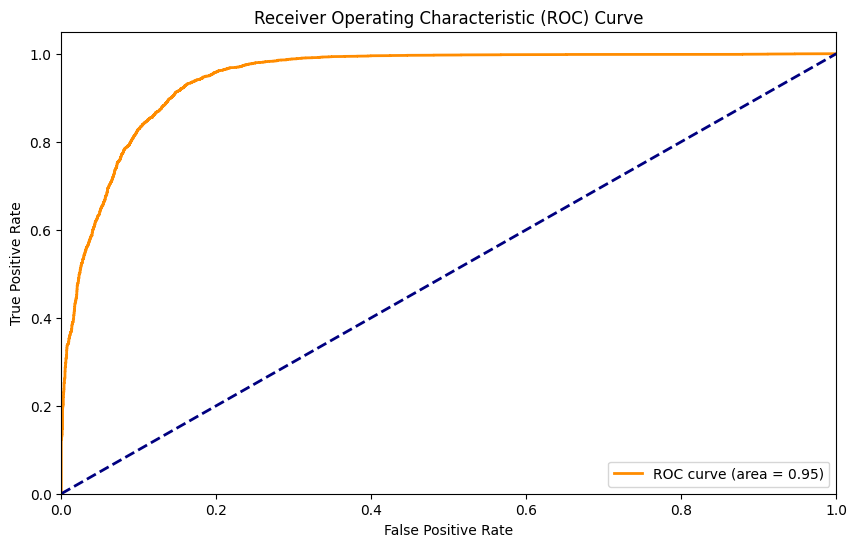

In [ ]:
# Receiver Operating Characteristic (ROC) Curves
eval_predictions = trainer.predict(tokenized_dataset['validation'])
true_labels = eval_predictions.label_ids

fpr, tpr, _ = roc_curve(true_labels, eval_predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

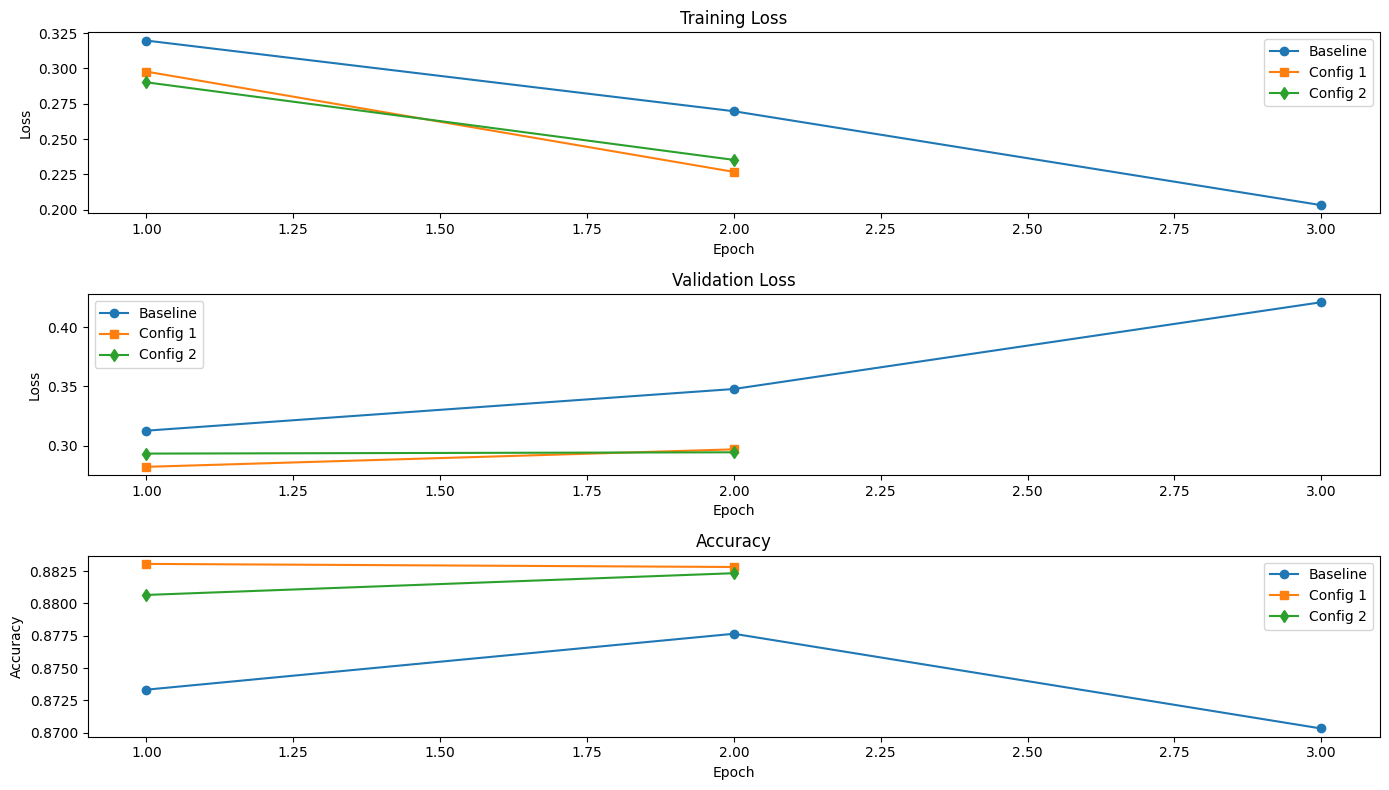

In [ ]:
import matplotlib.pyplot as plt
# Baseline Configuration
epochs_baseline = [1, 2, 3]
training_loss_baseline = [0.3198, 0.2697, 0.2031]
validation_loss_baseline = [0.312759, 0.347833, 0.420864]
accuracy_baseline = [0.873336, 0.877654, 0.870337]

# Configuration 1
epochs_config1 = [1, 2]
training_loss_config1 = [0.2978, 0.2267]
validation_loss_config1 = [0.28233, 0.297043]
accuracy_config1 = [0.883051, 0.882812]

# Configuration 2
epochs_config2 = [1, 2]
training_loss_config2 = [0.2902, 0.2352]
validation_loss_config2 = [0.293465, 0.294559]
accuracy_config2 = [0.880653, 0.882332]

plt.figure(figsize=(14, 8))

# Plot Training Loss
plt.subplot(3, 1, 1)
plt.plot(epochs_baseline, training_loss_baseline, 'o-', label='Baseline')
plt.plot(epochs_config1, training_loss_config1, 's-', label='Config 1')
plt.plot(epochs_config2, training_loss_config2, 'd-', label='Config 2')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Loss
plt.subplot(3, 1, 2)
plt.plot(epochs_baseline, validation_loss_baseline, 'o-', label='Baseline')
plt.plot(epochs_config1, validation_loss_config1, 's-', label='Config 1')
plt.plot(epochs_config2, validation_loss_config2, 'd-', label='Config 2')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(3, 1, 3)
plt.plot(epochs_baseline, accuracy_baseline, 'o-', label='Baseline')
plt.plot(epochs_config1, accuracy_config1, 's-', label='Config 1')
plt.plot(epochs_config2, accuracy_config2, 'd-', label='Config 2')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the validation dataset to get predictions
validation_results = trainer.predict(tokenized_dataset["validation"])

# Extract predictions and labels for validation set
validation_predictions = np.argmax(validation_results.predictions, axis=1)
validation_labels = validation_results.label_ids

In [ ]:
# Evaluate the model on the training dataset to get predictions
train_results = trainer.predict(tokenized_dataset["train"])

# Extract predictions and labels for training set
train_predictions = np.argmax(train_results.predictions, axis=1)
train_labels = train_results.label_ids

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Function to get loss and other metrics
def get_metrics(trainer, dataset, dataset_name=""):
    results = trainer.predict(dataset)
    predictions = np.argmax(results.predictions, axis=1)
    labels = results.label_ids
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1, predictions, labels

# Evaluate the model on the training dataset to get metrics

train_accuracy, train_precision, train_recall, train_f1, train_predictions, train_labels = get_metrics(trainer, tokenized_dataset["train"], "Training")

# Evaluate the model on the validation dataset to get metrics

validation_accuracy, validation_precision, validation_recall, validation_f1, validation_predictions, validation_labels = get_metrics(trainer, tokenized_dataset["validation"], "Validation")

# Evaluate the model on the test dataset to get metrics

test_accuracy, test_precision, test_recall, test_f1, test_predictions, test_labels = get_metrics(trainer, tokenized_dataset["test"], "Test")



Training Metrics:
Accuracy: 0.9236
Precision: 0.9253
Recall: 0.9238
F1 Score: 0.9235



Validation Metrics:
Accuracy: 0.8823
Precision: 0.8849
Recall: 0.8826
F1 Score: 0.8822



Test Metrics:
Accuracy: 0.8787
Precision: 0.8808
Recall: 0.8784
F1 Score: 0.8784


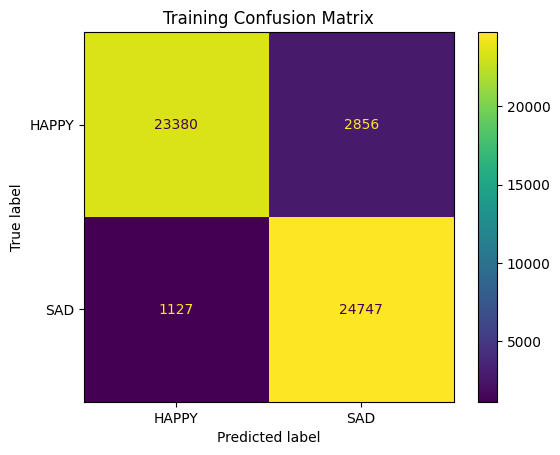

In [ ]:
# Calculate and display the confusion matrix for training set
train_conf_matrix = confusion_matrix(train_labels, train_predictions)
ConfusionMatrixDisplay(train_conf_matrix, display_labels=["HAPPY", "SAD"]).plot()
plt.title("Training Confusion Matrix")
plt.show()

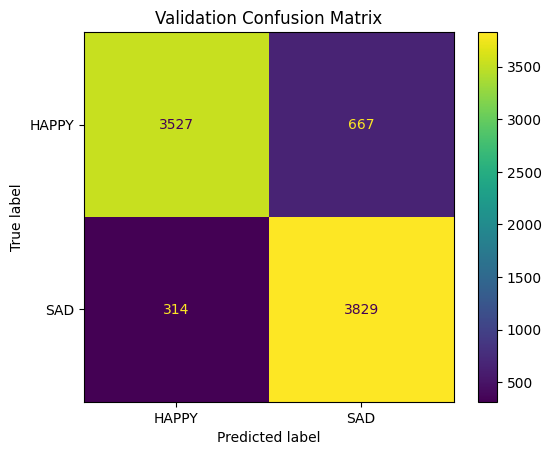

In [ ]:
# Calculate and display the confusion matrix for validation set
validation_conf_matrix = confusion_matrix(validation_labels, validation_predictions)
ConfusionMatrixDisplay(validation_conf_matrix, display_labels=["HAPPY", "SAD"]).plot()
plt.title("Validation Confusion Matrix")
plt.show()

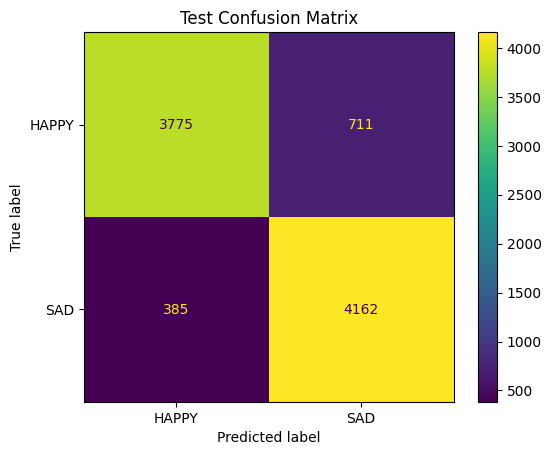

In [ ]:
# Calculate and display the confusion matrix for test set
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
ConfusionMatrixDisplay(test_conf_matrix, display_labels=["HAPPY", "SAD"]).plot()
plt.title("Test Confusion Matrix")
plt.show()